<a href="https://colab.research.google.com/github/blinov-89/CV_Success_Rockets_UDM/blob/main/%22Score_%3D_0_685454_(Success_Rockets_ipynb)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import transforms as tt
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
!nvidia-smi

Mon Jul 11 04:25:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['img_num'], self.data_df.iloc[idx]['number_of_houses']

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/Удм ИИ/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((500,500)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((500,500)),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# читаем датасет
data_df = pd.read_csv("/content/drive/MyDrive/Удм ИИ/train.csv")

In [ ]:
# Нам придется вычесть 1 что индексы классов начинались с 0.
data_df.number_of_houses = data_df.number_of_houses- 1


In [ ]:
data_df.head(3)

,img_num,number_of_houses
0,000000000611.jpg,8
1,000000000530.jpg,9
2,000000002787.jpg,9


In [ ]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/drive/MyDrive/Удм ИИ/train")))
print("Тестовой выборки " ,len(listdir("/content/drive/MyDrive/Удм ИИ/test_dataset_test")))

Обучающей выборки  2100
Тестовой выборки  900


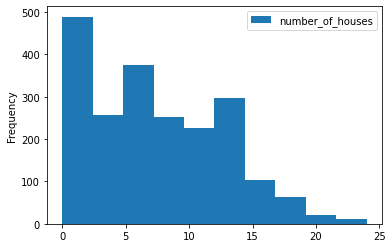

In [ ]:
data_df.plot.hist(by='sign')

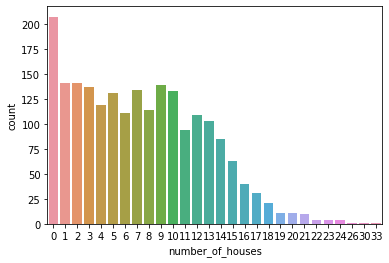

In [ ]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "number_of_houses" , data  = data_df)

Обратим внимание, что после 24 домов идет 26 и 30. В данных идут пропуски которые могут вызвать вызвать ошибки у CUDA. Выкинем такие данные.

In [ ]:
data_df = data_df[data_df.number_of_houses < 25]

In [ ]:
data_df.number_of_houses.unique()

array([ 8,  9,  1,  2, 10, 11,  5, 15, 16,  0, 14,  3,  6,  7, 20, 13, 12,
        4, 17, 21, 19, 18, 24, 22, 23])

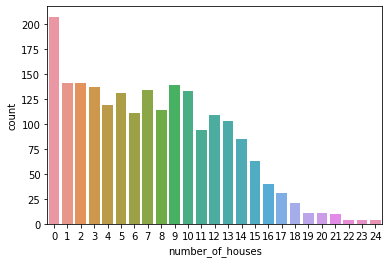

In [ ]:
sns.countplot(x = "number_of_houses" , data  = data_df)

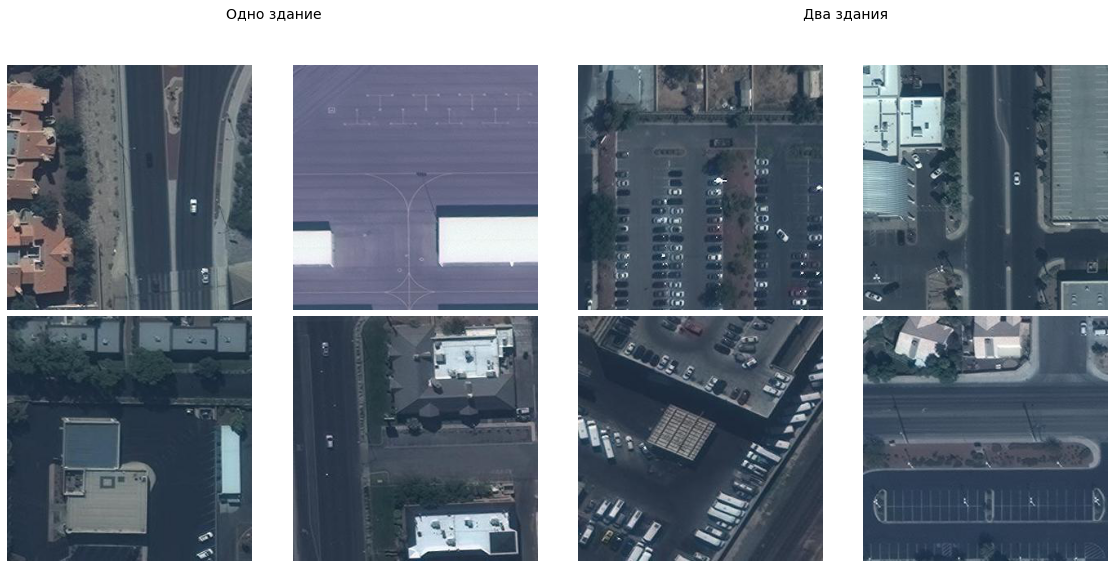

In [ ]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Одно здание {" "*105} Два здания', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['number_of_houses'] == 1 ].sample(4, random_state=42)['img_num']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/drive/MyDrive/Удм ИИ/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['number_of_houses'] == 2 ].sample(4, random_state=42)['img_num']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/drive/MyDrive/Удм ИИ/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
train_df, valid_df = train_test_split(data_df, test_size=0.25, random_state=42)

In [ ]:
train_df.shape, valid_df.shape

((1572, 2), (525, 2))

In [ ]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [ ]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=7):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)

    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc

    return train_score,val_score

In [ ]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 25)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, amsgrad=True)

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 25)

100%|██████████| 25/25 [21:38<00:00, 51.94s/it]

Train loss: 5.682306920602425
Val loss: 7.710861115228562
Train acc: tensor(56.9338, device='cuda:0')
Val acc: tensor(19.2381, device='cuda:0')


## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


In [ ]:
valid_df["pred"] = valid_predicts

In [ ]:
valid_df

,img_num,number_of_houses,pred
1937,000000002693.jpg,14,14
1459,000000001617.jpg,1,0
1767,000000001060.jpg,6,7
1739,000000000245.jpg,0,0
1441,000000000062.jpg,9,6
...,...,...,...
1189,000000000615.jpg,11,6
717,000000000593.jpg,2,0
290,000000002102.jpg,7,16
1898,000000002160.jpg,1,1


# Посчитаем accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [ ]:
valid_df['pred'].values

In [ ]:
val_accuracy = accuracy_score(valid_df['number_of_houses'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.1761904761904762


# Предскажем для теста

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Удм ИИ/sample_solution.csv")
test_df = test_df.drop(["number_of_houses"], axis = 1)

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['img_num']
        
        # читаем картинку
        image = cv2.imread(f"/content/drive/MyDrive/Удм ИИ/test_dataset_test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [ ]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)
    


100%|██████████| 29/29 [02:52<00:00,  5.95s/it]


In [ ]:
test_names=test_df['img_num'].tolist()

In [ ]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_names, predicts)], columns=['img_num', 'number_of_houses'])

In [ ]:
#Не забываем добавить 1 к предсказываемому лейблу
submit_df.number_of_houses = submit_df.number_of_houses + 1
submit_df

,img_num,number_of_houses
0,000000001801.jpg,8
1,000000001190.jpg,1
2,000000001817.jpg,10
3,000000000251.jpg,13
4,000000002505.jpg,7
...,...,...
895,000000002443.jpg,11
896,000000000856.jpg,4
897,000000001983.jpg,4
898,000000000166.jpg,2


In [ ]:
submit_df.to_csv("submit_udm.csv", index=False)